In [30]:
import sklearn as skl
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import plotly as ply
import plotly.express as px
import math as ma
import statsmodels as sta
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.style.use('seaborn')

In [31]:
bix_sta_prox = pd.read_csv('C:/Users/ckedd/Documents/Capstone data/bix_sta_prox.csv')
bix_sta_prox.drop(columns=['Unnamed: 0'], axis=1, inplace=True)

Now that I have established the best parameters for the model, using Decision trees to compensate for the large numbers of outliers in the data, I can move towards using more advanced modelling techniques. DecisionTree models have shown the best performance for me so far, at least in regard to $R^2$, So I will continue to use them in the form of Random Forests, at least initally. Random Forests are relatively high level models, and should provide good accuracy results. They are also relatively simple, so I can use them as a benchmarks to measure more complex models against later in this Notebook.

### Data Dictionary for Modelling (columns not included haven't been dropped, but will be ignored).

| column | data | 
|---|---|
| close stations | number of other stations within 500m of the target station |
| Distance from bixi center | Distance of the target station from the mean longitude and latitude of all bixi stations |
| points of interest prox count | The number of "points of interest" within 500m of the target station |
| Rec prox count | The number of recreation points of interest within 500m of the target station |
| public prox count | The number of public service points of interest within 500m of the target station |
| Cultural prox count | The number of cultural points of interst within 500m of the target station |
| Commercial prox count | The number of commercial points of interest within 500m of the target station |
| pop_density | The population density for the area surrounding the station |
| number of trips** | the total trips to and from the target station **model target |
| Metro prox count | A column showing how many Metro stations are within 200m of the target station |

In [32]:
bix_sta_prox.head()

,Metro prox count,close stations,Distance from bixi center,Distance from center,points of interest prox count,Rec prox count,public prox count,Cultural prox count,Commercial prox count,pk,name,latitude,longitude,pop_density,number of trips
0,0.0,8.0,8.193316,21.375417,14.0,6.0,6.0,2.0,0.0,10,Métro Angrignon (Lamont / des Trinitaires),45.446910,-73.603630,0.0,9321.0
1,0.0,4.0,6.712111,18.941373,7.0,3.0,4.0,0.0,0.0,13,Métro de l'Église (Ross / de l'Église),45.462726,-73.565959,11091.5,17037.0
2,0.0,7.0,6.429883,14.930417,13.0,11.0,1.0,0.0,1.0,17,Tolhurst / Fleury,45.544149,-73.667520,8987.1,5498.0
3,1.0,10.0,1.891975,12.761342,10.0,4.0,5.0,1.0,0.0,21,St-Christophe / Cherrier,45.520290,-73.568119,13566.4,9352.0
4,0.0,2.0,3.719539,10.452843,3.0,2.0,1.0,0.0,0.0,31,Lespérance / de Rouen,45.538839,-73.552779,14720.6,7556.0


In [33]:
from sklearn.model_selection import train_test_split

X = bix_sta_prox.drop(['number of trips', 'pk', 'name', 'longitude', 'latitude'], axis=1)
y = bix_sta_prox['number of trips']


X_CV, X_test, y_CV, y_test = train_test_split(X,y, test_size=0.2, random_state=1)

X_train, X_valid, y_train, y_valid = train_test_split(X_CV,y_CV, test_size=0.2, random_state=1)

For the first advanced model, I am using a Random Forest. Random Forest models are essentially a series of random decisions (the number of decision trees determined by the n_estimators variable), with the best model being selected. This helps, along with a gridsearch, to get the best hyper-parameters, as well as avoiding overfitting making Randon Forest essentially a better version of Decision Tree.

In [38]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
estimator = [
            ('model', RandomForestRegressor())]
pipe = Pipeline(estimator)

param_grid = [{
    'model' : [RandomForestRegressor()],
    'model__max_depth' : [3, 4, 5],
    'model__min_samples_leaf' : [1, 2, 3, 4, 5],
    'model__n_estimators' : [50, 100, 150],
    'model__criterion' :  ['squared_error', 'absolute_error']
}]

grid = GridSearchCV(pipe, param_grid, cv=5, verbose=1)

fittedgrid = grid.fit(X_train, y_train)
fittedgrid.best_params_

Fitting 5 folds for each of 90 candidates, totalling 450 fits


{'model': RandomForestRegressor(max_depth=4, n_estimators=150),
 'model__criterion': 'squared_error',
 'model__max_depth': 4,
 'model__min_samples_leaf': 1,
 'model__n_estimators': 150}

In [20]:

RF_reg_grid = RandomForestRegressor(max_depth= 4, min_samples_leaf=3, n_estimators=100)

RF_reg_grid.fit(X_train, y_train)

print(f"The accuracy of the model on trainig data, with optimised parameters is {RF_reg_grid.score(X_train, y_train)}")
print(f"The accuracy of the model on validation data, with optimised parameters is {RF_reg_grid.score(X_valid, y_valid)}")
print(f"The Mean Absolute Error of the validation data, with opitmised parameters {mean_absolute_error(y_valid, RF_reg_grid.predict(X_valid))}")

The accuracy of the model on trainig data, with optimised parameters is 0.5549401031792691
The accuracy of the model on validation data, with optimised parameters is 0.361087072037947
The Mean Absolute Error of the validation data, with opitmised parameters 6395.998820807026


The Random Forest model is the best model I have produced so far. The $R^2$ accuracy is better than the Decision Tree, after BoxCox transformations of the X-variables, whilst the Mean Absolute Error is superior to the SVR model, that had the best MAE score up to this point. One interest facet, is that the parameters over-fit significantly with a difference between the training and validation results of over 0.2. Despite this overfitting, the Random Forest was still incredibly accurate. To see why the model was so accurate, I will run the same visual model tests that I ran from the last Notebook, to see where errors were made.

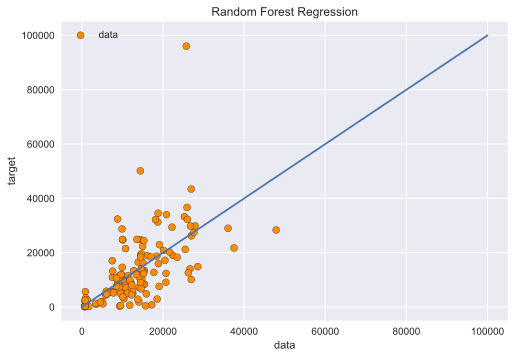

In [ ]:
y_2 = RF_reg_grid.predict(X_valid)
X_test.sort_index(inplace=True)
# Plot the results
plt.figure()
plt.scatter(y_2, y_valid, edgecolor="black", c="darkorange", label="data")
x= np.arange(0, 100000)
plt.plot(x,x)
#plt.scatter(X_test, y_2, color="yellowgreen", label="max_depth=3")
plt.xlabel("data")
plt.ylabel("target")
plt.title("Random Forest Regression")
plt.legend()
plt.show()

The graph above, shows similar issues to the other simple models, with outliers causing major problems, and stations with low trip totals becoming over-estimated. One notable difference between this graph and the SVR graph from my initial models, is that Random forest has higher predicted trip counts. This can be seen by the station with the most predicted trips having a prediction of over 40,000, whilst in the SVR graph, the station with the highest predicted number of trips was only predicted around 30,000. My choice of sticking with Decision Trees, seems to be correct, as the strengths of the SVR model (for instance), have been replicated by the Random Forest, whilst predicting higher trip counts, leading to a higher $R^2$ value.

To further examine how Random Forest deals with outliers, I will generate an error histogram, and see how it varies from the SVR version.

Text(0, 0.5, 'Frequency')

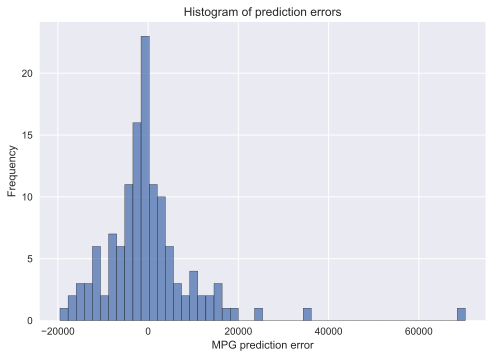

In [ ]:
diff = y_valid.values - y_2
sns.histplot(diff, bins = 50)
plt.title('Histogram of prediction errors')
plt.xlabel('MPG prediction error')
plt.ylabel('Frequency')

As expected, whilst the one massive outlier is still extremely obvious, the number of under-estimations, with trip count error over 20,000, is only 3, whereas for the SVR model, the number was 5. This confirms that the RandomForest is better at adjusting to outliers than SVR was, whilst maintaining the same accuracy, or similar accuracy, at the lower values.

The Random Forest graph, dispite adjusting better to outliers than the simpler models, still had extremely low maximum predictions. To improve the $R^2$ and Mean Absolute error, a model is needed that can increase the weighting of X-variables enough to predict higher values that can help the model better predict outlier stations with huge numbers of trips. Boosting models such as GradientBoostingRegressor, are great at this, as they re-run the model, then adjust the weightings in the X-variables, in order to improve the accuracy. 

In [ ]:
from sklearn.model_selection import train_test_split

X = bix_sta_prox.drop(['number of trips', 'pk', 'name', 'longitude', 'latitude'], axis=1)
y = bix_sta_prox['number of trips']


X_CV, X_test, y_CV, y_test = train_test_split(X,y, test_size=0.2, random_state=1)

X_train, X_valid, y_train, y_valid = train_test_split(X_CV,y_CV, test_size=0.2, random_state=1)

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
estimator = [('model', GradientBoostingRegressor())]
pipe = Pipeline(estimator)

param_grid = [{
    'model' : [GradientBoostingRegressor()],
    'model__n_estimators' : [25, 50, 100],
    'model__max_depth' : [1, 2, 3, 4],
    'model__min_samples_leaf' : [ 3, 4, 5, 6],
    'model__learning_rate' : [0.1, 0.15, 0.2, 0.25,0.3],
    'model__loss' : ['squared_error', 'absolute_error']
}]

grid = GridSearchCV(pipe, param_grid, cv=5, verbose=1)

fittedgrid = grid.fit(X_CV, y_CV)
fittedgrid.best_params_

Fitting 5 folds for each of 480 candidates, totalling 2400 fits


{'model': GradientBoostingRegressor(learning_rate=0.2, max_depth=2, min_samples_leaf=6,
                           n_estimators=25),
 'model__learning_rate': 0.2,
 'model__loss': 'squared_error',
 'model__max_depth': 2,
 'model__min_samples_leaf': 6,
 'model__n_estimators': 25}

In [ ]:
Grad_reg = GradientBoostingRegressor(learning_rate=0.2, max_depth=2, min_samples_leaf=6, n_estimators=25)
Grad_reg.fit(X_CV, y_CV)

print(f"The accuracy of the model on training data, with optimised parameters is {Grad_reg.score(X_train, y_train)}")
print(f"The accuaracy of the model on test data , with optimised parameters is {Grad_reg.score(X_test, y_test)}")
print(f"The Mean Absolute Error of the model on the test data with optimised parameters is {mean_absolute_error(y_test, Grad_reg.predict(X_test))}")

The accuracy of the model on training data, with optimised parameters is 0.5632603610345189
The accuaracy of the model on test data , with optimised parameters is 0.26371276583021264
The Mean Absolute Error of the model on the test data with optimised parameters is 7474.315583269361


The accuracy of the model is terrible, with huge amounts of overfitting. I chose to use the test dataset for this boosting model, as I want to maximise the training data. The previous models have all been relatively simple, so using a smaller dataset wasn't going to cause a major issue, and avoiding any bleed over from my test set into my results. However, for the more advanced models, such as boosting models, a large range of ranging data is important, as otherwise any data deficiencies will be increased by the model boosting values to improve accuracy.

The overfitting in the model is probably due to the n_estimators, and the small size of the dataset. A smaller number of estimators would likely reduce overfitting but, according to my GridSearch, hurt my accuracy too much. To see where the issues are occurring, I will plot the same style of scatterplot and histograms, to quantify the error, then I will look at how the model weighed the different X-variables, to help explain what is the most significant factors for the model.

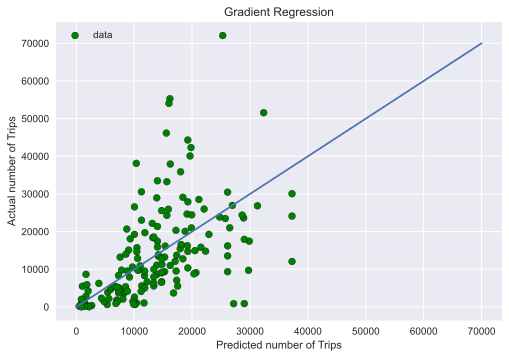

In [ ]:
y_2 = Grad_reg.predict(X_test)
# Plot the results
plt.figure()
plt.scatter(y_2, y_test, edgecolor="black", c="Green", label="data")
x= np.arange(0, 70000)
plt.plot(x,x)
plt.xlabel("Predicted number of Trips")
plt.ylabel("Actual number of Trips")
plt.title("Gradient Regression")
plt.legend()
plt.show()

The scatterplot, shows massive over-estimates on several stations. The test dataset has stations that are outliers, with the model heavily under-estimating all stations with more than 40,000 trips. The cause for this under-estimation, is potentially due to the test-set selection, as the data could be skewed with more popular stations, which would affect the model. However, a more likely cause is that there is a lack of data to separate similar stations. If a model is over-predicting and under-predicting with a similar number predicted trips (there is a large spread of stations predicted around 30,000 trips), it implies a lack of data.

Text(0, 0.5, 'Frequency')

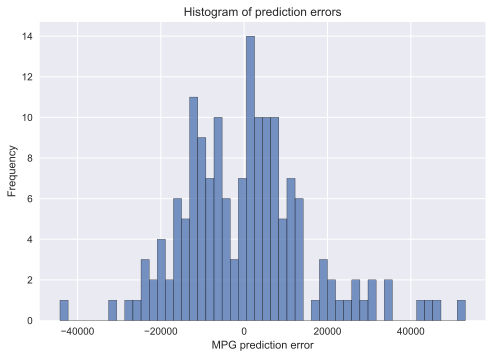

In [ ]:
diff = y_test.values - y_2
sns.histplot(diff, bins = 50)
plt.title('Histogram of prediction errors')
plt.xlabel('MPG prediction error')
plt.ylabel('Frequency')

Looking at the error histogram, there seems to be much more balance in how the Gradient regression predicts. Whilst there are definitely more extreme under-estimates (15 with more than 20,000 trips as an error), than extreme over-estimates(13 with less than -20,000 trips), the overall distribution of errors show that the model was over-estimating, compared to the RandomForest and earlier models which were over-estimating far less. The model seems to be trying to balance the errors between over and under estimations, but as a result has caused errors in both directions up to 40,000.

Looking at how importnat each feature was, will help to determine why the Gradient regression was so poor at predicting accurately. Given the previous graphs showing the accuracy of the predictions, I don't expect many significant features, as there seems to be a lack of deterministic data within the model.

Text(0.5, 1.0, 'Feature Importance (MDI)')

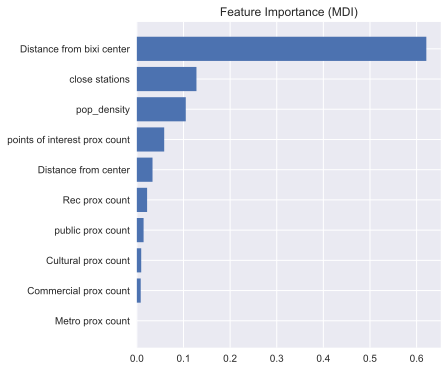

In [ ]:
feature_importance = Grad_reg.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align="center")
plt.yticks(pos, np.array(X.columns)[sorted_idx])
plt.title("Feature Importance (MDI)")

The feature importance in the Gradient Boosting model, shows that the main indicator of station poplarity is how close a station is to the center. The other somewhat significant data-points are "Close stations" and "pop_density", which both also favour stations towards the center of the city.

I want to attempt one more boosting model, to see if it can improve the final accuracy and potentially use different features. An AdaBoostRegression is a great choice, as it allows for Decision Trees (which were the most accurate models in the last notebook), to be used to build the basline of the model. The hope with an AdaBoostRegression model, is that there will be significantly less under-predictions, as using a relatively deep Decision Tree as a base, should allow for more extreme predictions, which would favour under-estimated stations.

A key factor about Adaboostregression, is that it modifies the data, after producing a large number (determined by n_estimators) of poor models (models that are only slightly better than random guesses). Over time, the adjusted models and data improve their accuracy and produce good results. The main issue is AdaBoostRegression, is that it can easily overfit as the models are fitted to the data, so too many n_estimators, will essentially fit the model to the data repeatably until the data is completely overfit.

In [ ]:
from sklearn.model_selection import train_test_split

X = bix_sta_prox.drop(['number of trips', 'pk', 'name', 'longitude', 'latitude'], axis=1)
y = bix_sta_prox['number of trips']


X_CV, X_test, y_CV, y_test = train_test_split(X,y, test_size=0.2, random_state=1)

X_train, X_valid, y_train, y_valid = train_test_split(X_CV,y_CV, test_size=0.2, random_state=1)

In [ ]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
AB_booster =  AdaBoostRegressor()
estimator = [('model', AdaBoostRegressor())]
pipe = Pipeline(estimator)


param_grid = [{
    'model' : [AdaBoostRegressor()],
    'model__base_estimator' : [DecisionTreeRegressor(max_depth=3), DecisionTreeRegressor(max_depth=4), DecisionTreeRegressor(max_depth=5), DecisionTreeRegressor(max_depth=6), DecisionTreeRegressor(max_depth=7)],
    'model__n_estimators' : [40, 50, 60, 70, 80, 90, 100],
    'model__learning_rate' : [ 0.005 ,0.05, 0.1, 0.15, 0.2,],
    'model__loss' : ['square', 'exponential']
}]

grid = GridSearchCV(pipe, param_grid, cv=5, verbose=1)

fittedgrid = grid.fit(X_CV, y_CV)
fittedgrid.best_params_

Fitting 5 folds for each of 350 candidates, totalling 1750 fits


{'model': AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=5),
                   learning_rate=0.05, loss='exponential'),
 'model__base_estimator': DecisionTreeRegressor(max_depth=5),
 'model__learning_rate': 0.05,
 'model__loss': 'exponential',
 'model__n_estimators': 50}

In Boosting models, the learning rate refers to how much the model changes variable weight, a low learning rate (such as 0.05) results in a model that will likely reach the best varable weights, but will do so slowly. The gradient descent the model undergoes to find the optimal weights, can result in a false bottom, which when the model settles of a good result because changing variables makes the result worse, however, the good result isn't necessarily the best result. A higher learning rate prevents this by pushing the variables, with momentum, over the false result. High learning rates, can however result in the model having too much momentum and never settling on the best result.

The exponential loss function, is an aggressive loss function based on maximising the exponential improvement of the model. This makes its results more extreme allowing for more aggressive divides in the data. The equation for exponential loss is shown below.
$$
y = a(1-b)^x
$$
In this equation, y is the loss total, a is the original amount, b is the decay factor and x is time passed, or cyles passed in the model's case. The x being a power, means that as the cycles in the model continue, the loss rate changes.

In [ ]:
from sklearn.metrics import mean_absolute_error
AB_boost = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=5), learning_rate=0.05, loss = 'exponential', n_estimators = 50)
AB_boost.fit(X_CV, y_CV)
print(f"The accuracy of the model on training data, with optimised parameters is {AB_boost.score(X_CV, y_CV)}")
print(f"The accuaracy of the model on testing data , with optimised parameters is {AB_boost.score(X_test, y_test)}")
print(f"The Mean Absolute Error of the model on testing data with optimised parameters it {mean_absolute_error(y_test,AB_boost.predict(X_test))}")

The accuracy of the model on training data, with optimised parameters is 0.5898716739120521
The accuaracy of the model on testing data , with optimised parameters is 0.35296348833929336
The Mean Absolute Error of the model on testing data with optimised parameters it 6886.853576103594


The results of the AdaBoostRegression are improved from the results of Gradient Boosting model, but an $R^2$ score of 0.35 isn't very impressive, the same way a Mean Absolute Error of 6887 is far more than I would feel comfortably in using for planning new stations. The model, too a lesser extent than the GradientBoostRegression, appears to be overfitting. An $R^2$ difference of 0.23 between training and testing data, means the model is too complex to accurately predict the test stations whilst being great a predicting the training stations. 

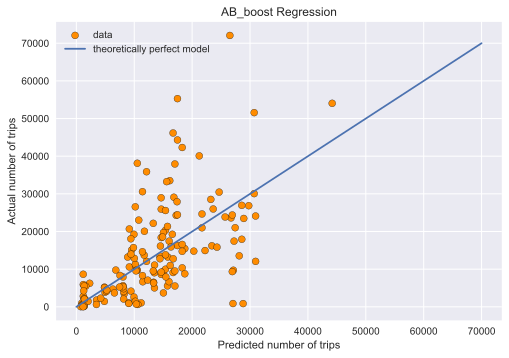

In [ ]:
y_2 = AB_boost.predict(X_test)
X_test.sort_index(inplace=True)
# Plot the results
plt.figure()
plt.scatter(y_2, y_test, edgecolor="black", c="darkorange", label="data")
x= np.arange(0, 70000)
plt.plot(x,x, label = 'theoretically perfect model')
#plt.scatter(X_test, y_2, color="yellowgreen", label="max_depth=3")
plt.xlabel("Predicted number of trips")
plt.ylabel("Actual number of trips")
plt.title("AB_boost Regression")
plt.legend()
plt.show()

The scatterplot shows a similar set of issues to the GradientBoostRegression, with the noticable exception that a few of the outliers are now much closer to the the perfect accuracy line, than before. The use of deep DecisionTrees, resulted in an increase in large predictions. Most of the improvement in R^2 is likely due to these changes, as a decrease in large errors, will have a massive impact on R^2, as seen by the 0.09 improving from the GradientBoostRegression. The Mean Absolute Error, was also improved but less so, as improving a small number of points by a large amount has a lower impact on Mean Absolute Error, as there are no multipliers applied, to favour reducing large errors, unlike in R^2.

To further quantify the differences between the two models, I will generate an error histogram, too see if a similar distribution to GradientBoostRegression occurred.

Text(0, 0.5, 'Frequency')

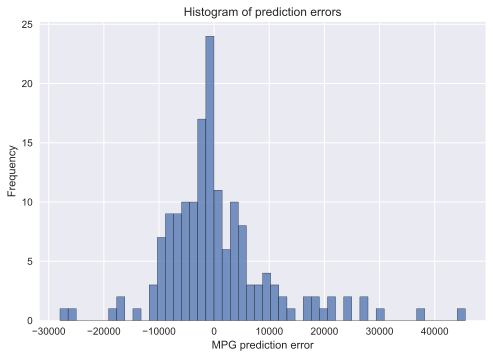

In [ ]:
diff = y_test.values - y_2
sns.histplot(diff, bins = 50)
plt.title('Histogram of prediction errors')
plt.xlabel('MPG prediction error')
plt.ylabel('Frequency')

The error histogram for AdaBoostRegression, is far better than the histogram for GradientBoostRegression. The main change is the decrease in over-predictions, with no data point being over-predicted by 30,000 or more, in comparison to the GradientBoostRegression, which had two such points. Whilst one of the massively under-estimated stations still shows up in the graph, with a error of over 40,000, it is a major improvement on the GradientBoostRegression which had 4 data points with an error of over 40,000. The AdaBoostRegression model is much better at dealing with stations that would be slightly under-estimated, with a steep dropoff of points after the zero bar. One clear weakness with the model is that a large number of points are over-estimated, meaning the model is more aggressive, which is helpful for dealing with some of the outliers in the data, but still severly hampers the accuacy and Mean Absolute Error score of the model.

Text(0.5, 1.0, 'Feature Importance (MDI)')

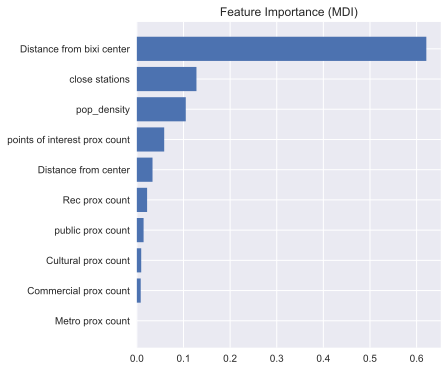

In [ ]:
feature_importance = Grad_reg.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align="center")
plt.yticks(pos, np.array(X.columns)[sorted_idx])
plt.title("Feature Importance (MDI)")

The final Feature Importance graph, shows the same data as the Gradient Boosting model, confirming that the "distance from the bixi center" is the only column with serious significance (a score greater than 0.2).

## Conclusions

### Final Model: Positives
The accuracy of the final model, whilst poor, was better than my previous boosting model and likely better than my other models, as the test dataset seemed to have more extreme outliers than the validation dataset I was using for the rest of my models. The model was also able to be get a large number of predictions entirely correct, with outliers being the main cause of issues in the model. In comparison to the other models I have attempted, the Adaboost model was able to predict higher values for some of the outliers, which shows that with additional data collection I would expect the Adaboost model to be the best for planning future bike hire stations.

### Final Model: Negatives
The main issue with the final model is the MAE and $R^2$ value, which both significantly below a score I would feel confortable using in to propose new stations (a $R^2$ score of 0.70+ would be around that point, with a MAE of around 1000). There are likely two causes for the poor model accuracy. Firstly there is a lack of data, the feature importance in the final model shows that only 4 of the 10 X-variables have a noticable impact on how the model calculates the regression predictions. Out of those 4 independent variables, main decider is clearly distance from Bixi center, with the number of close stations and population density being the other two really important ones, Points of Interest prox count is significant but less so than the other three.

If I continue this project, I would work on increasing the avaliable independent variables, as data such as metro station usage (rather than just metro station proximity) could shed more information on Bixi popularity. Data on other forms of public transport as well as bike lanes would also likely have an impact (those last two datasets do exist but are severely limited in scope), rather than using Points of Interest.

The second cause of the modelling error is likely a low validation and testing sample size. As there are only 797 Bixi stations in Montreal, the validation and testing dataset are liable to have large number of outliers, which the model may lack sufficient data to compensate for. The issue is that you cannot simply create new station datapoints without first increasing the investment into new stations, which this project was partially designed to assist. The alternative, would be for Bixi to move station locations by a small amount then maintain a multi-year average to see how slight differences in location have changed usage. This is only a suggestion/idea, due to the massive difference between the number of stations and the station codes, meaning stations have been opened, moved and shut down in the past.

## Final Views
My MVP for this project was to generate a list of the most important factors when determining a new bike hire station location. Whilst the accuracy of the final model, and the quantity of data leave a lot room for improvement, I can still fulfil the MVP and make some important suggetions from my data.

- 1 By far the most significant factor I found was the distance to the center. So if you building new stations, take the proximity to the center into account, as there will be more people to use the station and more places the cycle the bikes to.

- 2 Using Metro Stations as a modifier on its own isn't effective. The graph of Feature Importance in the Final model, shows no impact from Metro station proximity. Whilst I doubt that there is really no impact from integrating other transport services into Bike hire systems, it is clear that more data is needed than simply working out if there is a station nearby. One suggestion that put in the negatives of my final model was that extensions on this model could involve station usage, as this would allow for separating small metro stations, from the largest ones. Given that station density was one of the determining factors, and the highest station density was around the central station, it supports the argument that a scaling factor is needed, before integrating train and metro stations into the model, ideally scaling factors based on station foot traffic.

- 3 Using demographic data such as Population Density isn't an incredibly useful factor when modelling station popularity, only accounting for just over 10% of the model accuracy, for my final model. The main strength of demographic data is the relative ease of aquisition, as any place large enough to justify a bike hire scheme, is also likely to have had population surveys, which would contain Population Density data. This should make demograph data more accessable, although not the most important feature.

- 4 Landmark data only matters if it is not granular, or if you have an extremely extensive dataset. Looking at the Feature importance, the Points of interest data is the most disappointing, as the only valuable Points of interest column is the generalised one. Whilst the data I collected supports the theory that landmarks influence bike hire station usage, the extent of the data required for landmarks to become a major feature, would be far greater than what I had, and would likely require weighting the points of interest based on footfall, which was what I tried to do here but couldn't find the data.

### How I would continue/improve this project

If I were to continue this project, the most important change would be to increase the amount of data. As mentioned earlier, adding footfall data when to help quantify the importance of different Points of interest, as well as making proximity to other forms of public transport such as Metro stations a viable measure. Furthermore, a more scientific description and method for finding the "center of activity" or "Bixi center", would be a major improvement, as it would allow for easier adaptation from Montreal to other cities.

New columns I would add if I continued this project would be: Income distribution data, more extensive land-use data (is an area a highstreet with small businesses, or a residential street) and extensive bike lane statistics. Income distribution, could be a useful metric, as Bixi bikes require either a membership or one-off payment to use. This could potentially cause a pay barrier reducing the number of people who use Bixi in certain areas. Income distribution, could also impact station usage due to richer individuals tending to use cars more, which would mean they would be less likely to use bike hires.

Extensive land-use data could further describe what surround popular stations and makes them popular. However, granular points of interest data wasn't significant in my models for this project, so there is a chance that the new land-use data, on its own, would be similarly ineffective at determining why individuals choose to use specific stations.

Bike lane statistics are frustrating to find in Montreal, the statistics I could find for this project were extremely limited, and therefore were dropped in during my EDA. Bike lanes should have an impact on bike hire schemes, as cities that have improved the quality of cycling instrastructure, such as London, have seen an increaes in bike use. This is because people feel much safer cycling with proper bike lanes, this should have an impact on Bixi usage even more than on regular bikes, as new cyclists are more likely to use Bixi than buy a new bike to use on the bike lanes. The main issue with bikelane data is that it is very hard to quantify: how many bikelanes are there nearby, do those bikelanes lead to important and useful locations and how good are the bike lanes (some bikelanes are significantly worse than others).

Another goal of an extension to this project would be to map popular bike routes and attempt to find seasonality and focus points for either future stations or furtuer bike lane infrastructure. To plot seasonality, I would need a much larger, multi-year dataset which does exist, but is impacted by covid lockdown skewing the data. Plotting routes would be a challenge, as knowing a start and end point, does not necessarily tell you a route (using google maps could result in suggested routes that travel along major roads for instance). Due to these challenges, I would need to work with several apis to create some theoretical routes then test to see how good the bike infrastructure along those routes is. This would require extensive bike lane data, which unfortunately I don't have.